In [2]:
# fix for windows memory leak with MKL
import os
import platform

if platform.system() == "Windows":
    os.environ["OMP_NUM_THREADS"] = "2"

# import libraries
import time
import random
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt  # this is used for the plot of the graph
from adjustText import adjust_text
from scipy.stats import mode, zscore, median_abs_deviation
import joblib
# Sklearn classes
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    GridSearchCV,
    KFold,
)
from sklearn import metrics
from sklearn.metrics import confusion_matrix, silhouette_score, make_scorer, recall_score, f1_score
import sklearn.metrics.cluster as smc
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import (
    StandardScaler,
    OneHotEncoder,
    LabelEncoder,
    MinMaxScaler,
)
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import StratifiedKFold
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn import tree
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_blobs
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import Normalizer
from sklearn.ensemble import RandomForestClassifier, IsolationForest

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from helper import (
    draw_confusion_matrix,
    heatmap,
    make_meshgrid,
    plot_contours,
    draw_contour,
)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Sets random seed for reproducibility
SEED = 42
random.seed(SEED)

In [3]:
# Load Data
data = pd.read_csv("Data_Raw.csv", header=1)
sites = data['site']
niki = pd.read_csv("Data_Niki.csv")
niki = niki.drop(index=[0,1])
niki['Engineer classification.1'] = (niki['Engineer classification.1'] == 'Release').astype(int)
y = niki['Engineer classification.1']

# Dropping Unnecessary Rows and Columns
filtered_ordered_columns = [col for col in niki['Parameter name'] if col in data.columns]
data = data[filtered_ordered_columns]
data = pd.concat([sites, data], axis=1)
data = data.apply(pd.to_numeric, errors='coerce') 

# Obtaining Median and Std for Each Site and Each Parameter
med = data.groupby('site').median()
std = data.groupby('site').std()

# med = med.fillna(0)
# std = std.fillna(0)

med = med.T.copy()
std = std.T.copy()

C:\Users\nxg15046\AppData\Local\Temp\1\ipykernel_4680\3059869606.py:4: DtypeWarning: Columns (1,2,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,

In [4]:
# Standardizing by Row
z_med = med.apply(zscore, axis=1, nan_policy='omit')
z_med = pd.DataFrame(z_med.tolist(), index=med.index, columns=med.columns)
z_std = std.apply(zscore, axis=1, nan_policy='omit')
z_std = pd.DataFrame(z_std.tolist(), index=std.index, columns=std.columns)

In [5]:
# Range (need to remove lower and upper limit)
z_med_min = z_med.min(axis=1)
z_std_min = z_std.min(axis=1)
z_med_max = z_med.max(axis=1)
z_std_max = z_std.max(axis=1)
z_med_range = z_med_max - z_med_min
z_std_range = z_std_max - z_std_min

## Inter-Quartile Range
Q1_med = z_med.quantile(0.25, axis=1)
Q3_med = z_med.quantile(0.75, axis=1)
z_med_iqr = Q3_med - Q1_med
Q1_std = z_std.quantile(0.25, axis=1)
Q3_std = z_med.quantile(0.75, axis=1)
z_std_iqr = Q3_std - Q1_std

## Median Absolute Deviation
z_med_mad = z_med.apply(median_abs_deviation, axis=1)
z_std_mad = z_std.apply(median_abs_deviation, axis=1)

## Skewness
med_skewness = med.skew(axis=1)
std_skewness = std.skew(axis=1)

## Kurtosis (Propensity for Outliers)
med_kurtosis = med.kurt(axis=1)
std_kurtosis = std.kurt(axis=1)

In [6]:
# Concatenating All Features
y.index = z_med.index
x = pd.concat([z_med_range, z_std_range, z_med_iqr, z_std_iqr, z_med_mad, z_std_mad, med_skewness, std_skewness, med_kurtosis, std_kurtosis, y], axis=1)

# Assigning New Column Names to Bypass Column Name Repeating Issue
num_columns = x.shape[1]
x.columns = x.columns.astype(str)
new_columns = ["z_med_range", "z_std_range", "z_med_iqr", "z_std_iqr", "z_med_mad", "z_std_mad", "med_skewness", "std_skewness", "med_kurtosis", "std_kurtosis", "y"]
x.columns = new_columns

corr_matrix = x.corr(numeric_only=True)
print(corr_matrix["y"].sort_values(ascending=False))
x = x.drop('y', axis=1)

y               1.000000
z_med_mad       0.651143
z_med_iqr       0.560460
med_skewness    0.424884
z_std_iqr       0.396754
z_std_mad       0.229869
std_kurtosis   -0.081305
std_skewness   -0.150456
z_std_range    -0.165742
z_med_range    -0.689467
med_kurtosis   -0.743451
Name: y, dtype: float64


c:\Users\nxg15046\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Test Accuracy: 0.989891
Precision:   0.970297
Recall:      0.963145
F1 Score:    0.966708


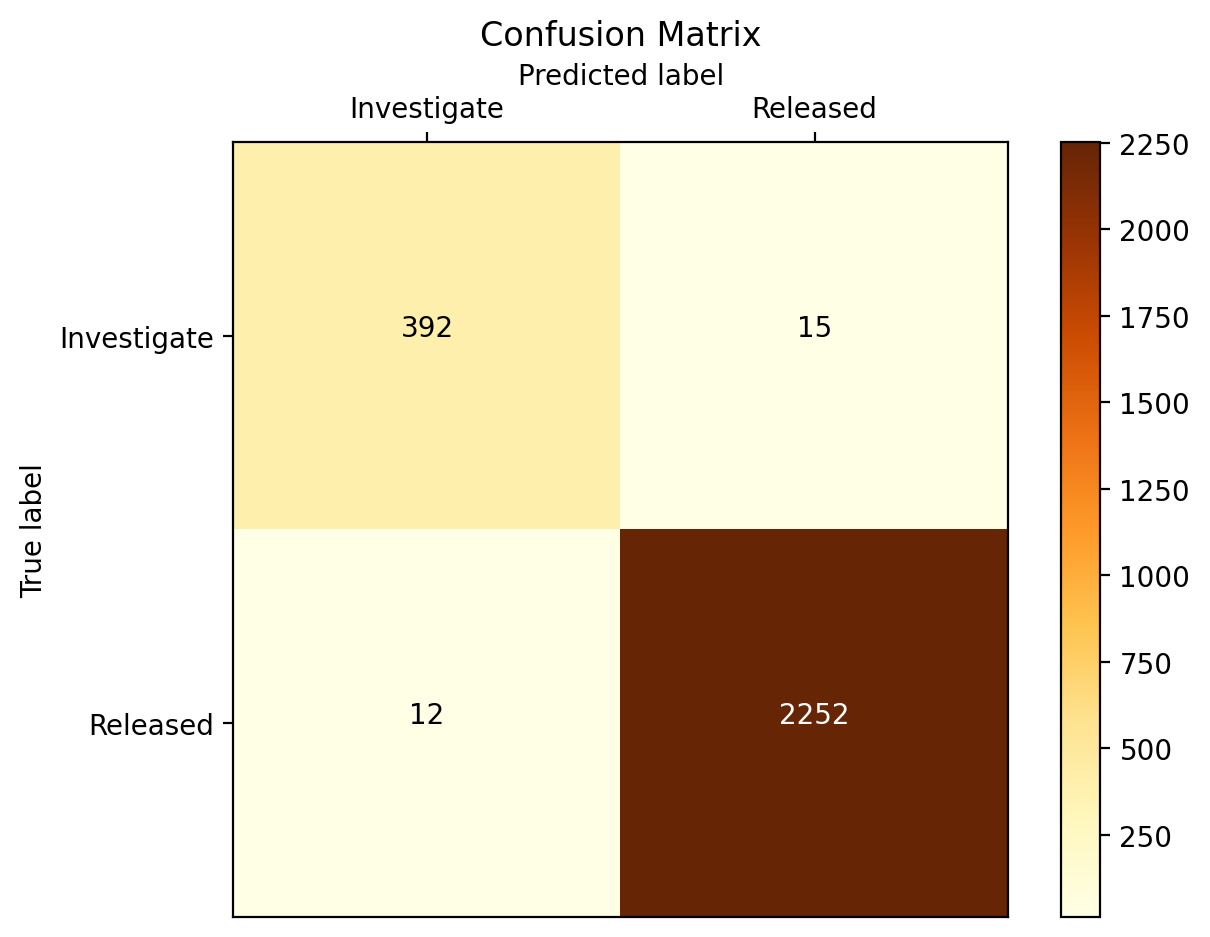

In [8]:
# LGBM Model Trained with No Imputation
raw_loaded = joblib.load('lgbm_raw_noimpute.pkl')
pipeline_impute = joblib.load('pipeline_noimpute.pkl')

x_transformed = pipeline_impute.transform(x)
predictions = raw_loaded.predict(x_transformed)

accuracy = metrics.accuracy_score(y, predictions)
precision = precision_score(y, predictions, pos_label=0)
recall = recall_score(y, predictions, pos_label=0)
f1 = f1_score(y, predictions, pos_label=0)

print("%-12s %f" % ('Test Accuracy:', accuracy))
print("%-12s %f" % ('Precision:', precision))
print("%-12s %f" % ('Recall:', recall))
print("%-12s %f" % ('F1 Score:', f1))

draw_confusion_matrix(y, predictions, ['Investigate', 'Released'])

c:\Users\nxg15046\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Test Accuracy: 0.946088
Precision:   0.878963
Recall:      0.749386
F1 Score:    0.809019


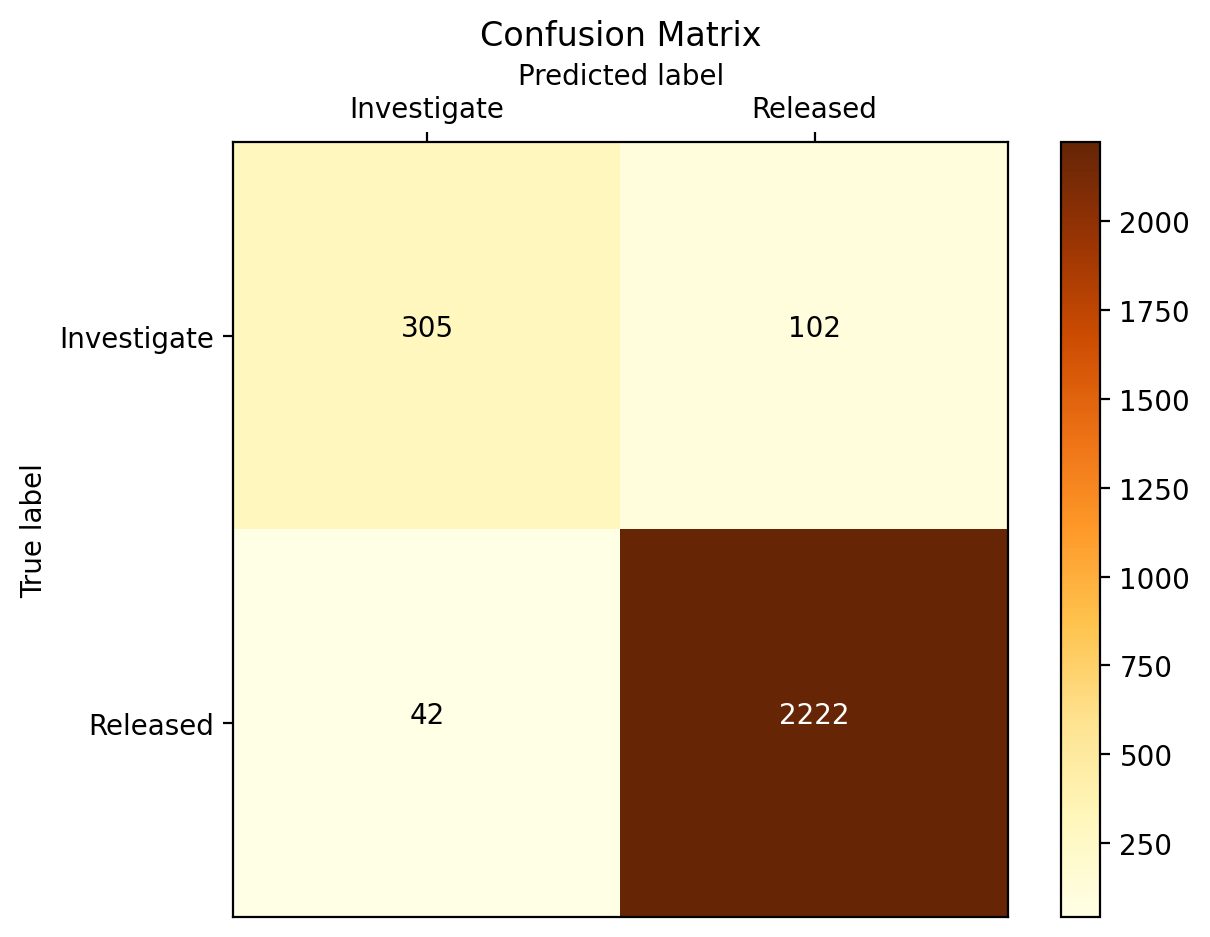

In [10]:
# LGBM Model with Imputation
raw_loaded = joblib.load('lgbm_niki_impute.pkl')
pipeline_impute = joblib.load('pipeline_impute.pkl')

x_transformed = pipeline_impute.transform(x)
predictions = raw_loaded.predict(x_transformed)

accuracy = metrics.accuracy_score(y, predictions)
precision = precision_score(y, predictions, pos_label=0)
recall = recall_score(y, predictions, pos_label=0)
f1 = f1_score(y, predictions, pos_label=0)

print("%-12s %f" % ('Test Accuracy:', accuracy))
print("%-12s %f" % ('Precision:', precision))
print("%-12s %f" % ('Recall:', recall))
print("%-12s %f" % ('F1 Score:', f1))

draw_confusion_matrix(y, predictions, ['Investigate', 'Released'])